<a href="https://colab.research.google.com/github/glingden/MachineLearning/blob/master/CIFAR10_with_Keras_tunner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###CIFAR10 with Simple ANN using  Keras-tunner and VGG network
 Keras-tunner is used for finding the best hyper-paramerter for ANN. In addition, VGG network is also applied and achieved around 86% test accuracy.

In [ ]:
# for gpu tensorflow
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 52kB/s 


In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import keras
import scipy.stats
import matplotlib.pyplot as plt
import pickle
import glob
import time
from random import random
from skimage.transform import rescale, resize
from keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
# Mount the drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Helper function to load images
def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding="latin1")
    return dict



In [ ]:
# Change image size to given scale
def cifar10_color(data, im_rescale):
    """
    Convert an image of(n , 32, 32,3) into given size and flatten them.

    :param
    data(ndarray): Image data

    :return(ndarray):
    Resized image  size
    """

    resized_img_array = np.zeros((data.shape[0], im_rescale * im_rescale * 3))  # store resized image array
    for i in range(data.shape[0]):  # loop through each image
        img_1x1 = resize(data[i], (im_rescale, im_rescale))  # resize (32,32) to (resize,resize)
        resized_img_array[i, :] = img_1x1.flatten()

    return resized_img_array



In [ ]:
# Install keras-tunner for hyper-parameter tunning
!pip install -U keras-tuner
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch, Hyperband

     |████████████████████████████████| 61kB 2.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=82031817af979c4be4d3413660f09fd4708f1d799cdfd87957c9488403299c12
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=432137a5009d415d9fd4fa683a6736a25d1cd6994e10e264279fd8c9bebbb722
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
# ANN using keras-tunner 
class Cifar_10_hyper_tunner(HyperModel):

  def __init__(self, num_class, input_shape):
    self.num_class = num_class
    self.input_shape = input_shape

  # Model build function
  def build(self, hp):
    model = Sequential()
    model.add(layers.Flatten(input_shape=self.input_shape))
    model.add(layers.Dense(units=hp.Int("units",
                                        min_value=32,
                                        max_value=512, 
                                        step=64,
                                        default=128), activation="relu"))
    model.add(layers.BatchNormalization()) # Batch normalization

    # No. of Dense Layers
    for layer in range(hp.Int('layers', 1, 4)):
      model.add(layers.Dense(units=hp.Int(f"units_{layer}", 
                                            min_value=32,
                                            max_value=512, 
                                            step=64,
                                            default=128),
                        activation=hp.Choice(f"activation_{layer}",
                                            values=["relu","tanh", "sigmoid"],
                                            default="relu")))  
      model.add(layers.BatchNormalization()) # Batch normalization
      model.add(layers.Dropout(rate=hp.Float(f"dropout_{layer}",
                                            min_value=0.0,
                                            max_value=0.5,
                                            default=0.25,
                                            step=0.05,)))

    model.add(layers.Dense(units=128, activation='relu'))
    model.add(layers.BatchNormalization()) # Batch normalization                              
    model.add(layers.Dense(self.num_class , activation='softmax'))  # Output layer
    # Compile with  configuration
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.RMSprop( 
                      hp.Float(
                          "learning_rate",
                          min_value=1e-4,
                          max_value=1e-2,
                          sampling="log",
                          default=1e-3)), # Learning rate
                  metrics=['accuracy']) 
              
    return model


  

In [ ]:

# CNN model with VGG network (weights initialized with  uniform distribution)
def CNN_Cifar10_model(num_classes, input_shape):
  model = Sequential() # Sequential model
  # Convolution layers
  model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
  model.add(BatchNormalization()) # Batch Normalization
  model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization()) # Batch Normalization
  model.add(MaxPooling2D(pool_size=(2, 2))) # MaxPooling
  model.add(Dropout(rate=0.25))# Dropout

  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2))) # MaxPooling
  model.add(Dropout(rate=0.35))# Dropout

  model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2))) # MaxPooling
  model.add(Dropout(rate=0.45))# Dropout

  model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2))) # MaxPooling
  model.add(Dropout(rate=0.55))# Dropout
  

  # Flatten and Dense layer
  model.add(Flatten())
  model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Dropout(rate=0.5))
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Dropout(rate=0.5))
  model.add(Dense(num_classes, activation='softmax')) # Output layer
  # Compile Model with  configuration
  model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Learning rate
                metrics=['accuracy'])
  return model




In [ ]:
!rm -rf RandomSearch/

In [ ]:
%%time
# ANN training
if __name__ == "__main__":

    np.random.seed(100)  # seed random generator

    # Test data
    test_datadict = unpickle('/content/drive/My Drive/Data/cifar-10-batches-py/test_batch')  # change file path
    test_data = test_datadict['data']  # test data
    # test_data = test_data.astype(np.int16)  # change data type
    test_data = test_data.reshape(test_data.shape[0], 3, 32, 32).transpose(0, 2, 3, 1).astype("uint8")  # reshape to orignal image size
    test_labels = np.array(test_datadict['labels'], dtype=np.int16)  # test labels
    print('Test data shape:  {}'.format(test_data.shape))
    print('Test Labels shape:  {}\n'.format(test_labels.shape))

    # Train dataset
    data_batchs = glob.glob('/content/drive/My Drive/Data/cifar-10-batches-py/data_batch*')  # list of data_batches' paths
    train_data = np.empty(shape=[0, 3072], dtype=np.int16)  # empty array for train data
    train_labels = np.empty(shape=[0], dtype=np.int16)  # empty array for train labels

    # Concatenate all Train data_batches
    for batch in data_batchs:
        train_datadict = unpickle(batch)  # unpickle file
        data_batch = train_datadict['data']  # batch data
        train_data = np.vstack((train_data, data_batch))  # stack batches data

        batch_labels = np.array(train_datadict['labels'])  # batch labels
        train_labels = np.hstack((train_labels, batch_labels))  # stack batches labels

    # Reshape to orginal image size
    train_data = train_data.reshape(train_data.shape[0], 3, 32, 32).transpose(0, 2, 3, 1).astype("uint8")
    print('Train data shape:  {}'.format(train_data.shape))
    print('Train Labels shape:  {}\n'.format(train_labels.shape))

    # Scaled image with min-max scaler
    train_data = train_data / 255.0
    test_data = test_data / 255.0
    train_labels_cat = to_categorical(train_labels)  # one-hot encoding
    test_labels_cat = to_categorical(test_labels)
    
    
    # RandomSearch Hyper-Parameter Tunner
    input_shape = (32,32,3) # Image shape
    num_class = 10 # Total classes
    hype_tunner = Cifar_10_hyper_tunner( num_class = num_class, input_shape=input_shape) # Create hyper-model class instance
    model_tuner = RandomSearch(hype_tunner,
                              objective='val_accuracy',
                              max_trials=20, # Total no. of trails to perform
                              executions_per_trial=2, # No. of test in a trail (reduce results variance)
                              directory='RandomSearch',
                              project_name='Cifar_10')

    # Show a summary of the search
    model_tuner.search_space_summary()

    # Fit train data for Hyper-parameters search
    early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max')  # Early stopping 
    model_tuner.search(x=train_data, 
                       y=train_labels_cat,
                       epochs =100, 
                       shuffle = True,
                       batch_size=32,
                       validation_split=0.2, 
                       callbacks=[early_stop], 
                       verbose=0) # Parameter search


    # Show best hyper-parameters and best-model summary
    print(f"Best hyper-parameter: \n {model_tuner.get_best_hyperparameters()[0].values}")
    print(f"Best Model Summary: \n {model_tuner.get_best_models()[0].summary()}")





    

Test data shape:  (10000, 32, 32, 3)
Test Labels shape:  (10000,)

Train data shape:  (50000, 32, 32, 3)
Train Labels shape:  (50000,)



INFO:tensorflow:Oracle triggered exit
Best hyper-parameter: 
 {'units': 480, 'layers': 2, 'units_0': 416, 'activation_0': 'tanh', 'dropout_0': 0.05, 'learning_rate': 0.0006847022000929066, 'units_1': 416, 'activation_1': 'tanh', 'dropout_1': 0.30000000000000004, 'units_2': 32, 'activation_2': 'relu', 'dropout_2': 0.4, 'units_3': 160, 'activation_3': 'sigmoid', 'dropout_3': 0.30000000000000004}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 480)               1475040   
_________________________________________________________________
batch_normalization (BatchNo (None, 480)               1920      
_________________________________________________________________
dense_1 (Dense)              (None, 416)               

In [ ]:
# Evaluate test data with the best model
best_model = model_tuner.get_best_models(num_models=1)[0]  # best model
loss, accuracy = best_model.evaluate(test_data, test_labels_cat)  # Evaluation
print(accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 1.3351 - accuracy: 0.5407
0.5407000184059143


###CNN model Training

In [ ]:

# Test data
test_datadict = unpickle('/content/drive/My Drive/Data/cifar-10-batches-py/test_batch')  # change file path
test_data = test_datadict['data']  # test data
# test_data = test_data.astype(np.int16)  # change data type
test_data = test_data.reshape(test_data.shape[0], 3, 32, 32).transpose(0, 2, 3, 1).astype("float32")  # reshape to orignal image size
test_labels = np.array(test_datadict['labels'], dtype=np.int16)  # test labels
print('Test data shape:  {}'.format(test_data.shape))
print('Test Labels shape:  {}\n'.format(test_labels.shape))

# Train dataset
data_batchs = glob.glob('/content/drive/My Drive/Data/cifar-10-batches-py/data_batch*')  # list of data_batches' paths
train_data = np.empty(shape=[0, 3072], dtype=np.int16)  # empty array for train data
train_labels = np.empty(shape=[0], dtype=np.int16)  # empty array for train labels

# Concatenate all Train data_batches
for batch in data_batchs:
    train_datadict = unpickle(batch)  # unpickle file
    data_batch = train_datadict['data']  # batch data
    train_data = np.vstack((train_data, data_batch))  # stack batches data

    batch_labels = np.array(train_datadict['labels'])  # batch labels
    train_labels = np.hstack((train_labels, batch_labels))  # stack batches labels


# Scaled image with min-max scaler
train_data = train_data / 255.0
test_data = test_data / 255.0
train_labels_cat = to_categorical(train_labels)  # one-hot encoding
test_labels_cat = to_categorical(test_labels)

# Reshape to orginal image size
train_data = train_data.reshape(train_data.shape[0], 3, 32, 32).transpose(0, 2, 3, 1).astype("float32")
print('Train data shape:  {}'.format(train_data.shape))
print('Train Labels shape:  {}\n'.format(train_labels.shape))


Test data shape:  (10000, 32, 32, 3)
Test Labels shape:  (10000,)

Train data shape:  (50000, 32, 32, 3)
Train Labels shape:  (50000,)



In [ ]:
!rm -rf RandomSearch/

In [ ]:
%%time
input_shape = (32,32,3) # Image shape
num_class = 10 # Total classes
CNN_tuner_instance = CNN_Cifar10_model(num_class, input_shape) # Initiate model
CNN_tuner_instance.summary()

# Callbacks
model_path='/content/RandomSearch/CNNCifar_10/CNN' # location to save best model
early_stop=EarlyStopping(monitor='val_accuracy', 
                         patience=10,
                         mode='max') # Early stopping
model_check=ModelCheckpoint(model_path,
                            monitor='val_accuracy', 
                            save_best_only=True, 
                            mode='max') # Save model with best val-score


history = CNN_tuner_instance.fit(x=train_data, 
                                y=train_labels_cat,
                                epochs =100, 
                                shuffle = True,
                                batch_size=64,
                                validation_split=0.2,
                                #validation_data =(test_data, test_labels_cat),
                                callbacks=[early_stop,model_check], 
                                verbose=1)



Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_129 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_155 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_156 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_77 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 16, 16, 64)      

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

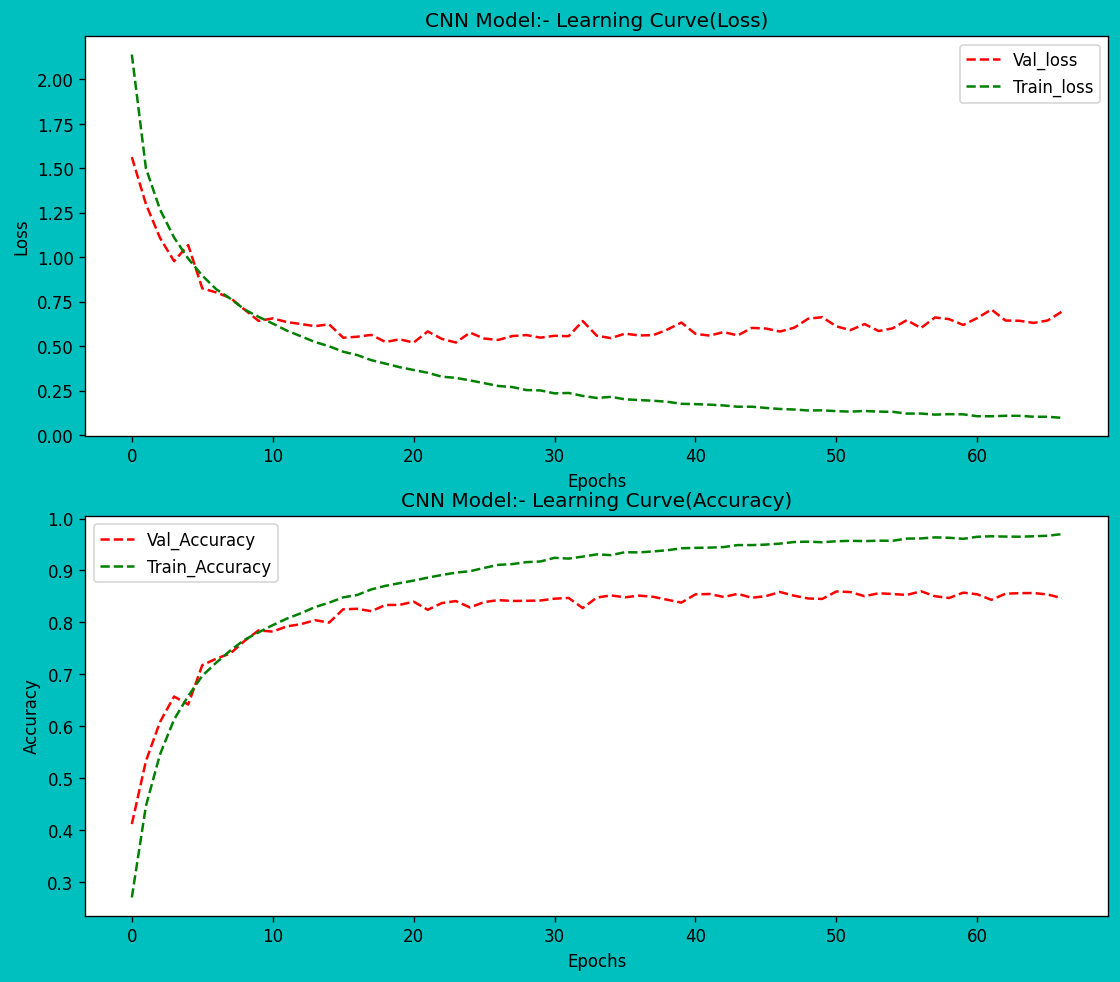

In [ ]:
# Plot Model Learning Curve
plt.figure(1, figsize=(11, 15), dpi=120, facecolor='c')
# Loss plot
plt.subplot(311)
plt.plot(history.history['val_loss'], 'r--', label='Val_loss')
plt.plot(history.history['loss'],'g--', label='Train_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model:- Learning Curve(Loss)')
plt.legend()

# Accuracy plot
plt.subplot(312)
plt.plot(history.history['val_accuracy'], 'r--', label='Val_Accuracy')
plt.plot(history.history['accuracy'],'g--', label='Train_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Model:- Learning Curve(Accuracy)')
plt.legend()
plt.show()

In [ ]:
# Evaluate Test data
CNN_model = keras.models.load_model('/content/RandomSearch/CNNCifar_10/CNN') # load best model
score_cnn = CNN_model.evaluate(test_data, test_labels_cat) # evaulate on test data
print('Test accuracy:', score_cnn[1])


313/313 [==============================] - 2s 5ms/step - loss: 0.5834 - accuracy: 0.8618
Test accuracy: 0.8618000149726868


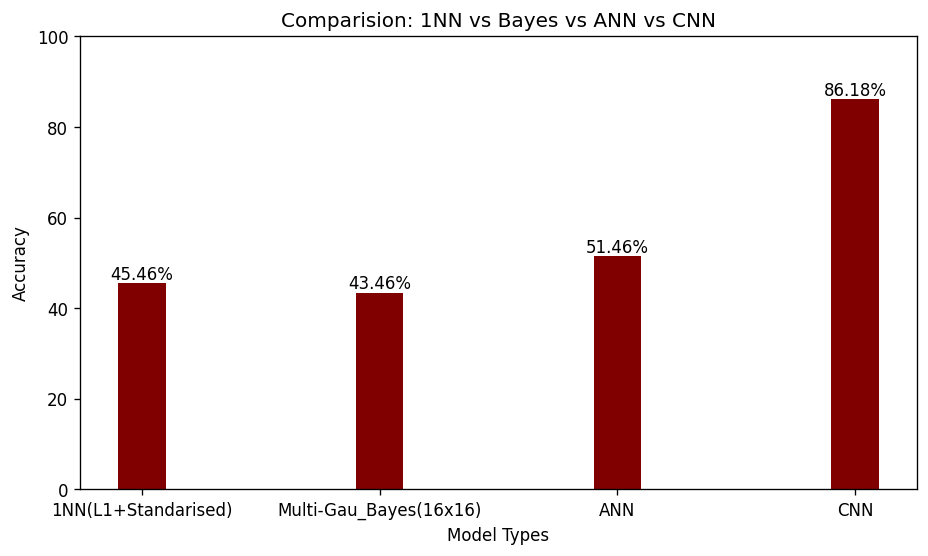

In [ ]:
# Model Comparision Plot
accuracy = [45.46, 43.46, 51.46, 86.18] # Y-values (Accuracy score from each model types)
x = ['1NN(L1+Standarised)', 'Multi-Gau_Bayes(16x16)', 'ANN', 'CNN'] # X-values
fig, ax = plt.subplots(figsize = (9,5), dpi=120) # Set figure
bar_plot = plt.bar(x, accuracy, width=0.2,color ='maroon') # Barchart plot
for x in bar_plot: # Get (x,y) co-ordinates
  height = x.get_height() # Get bar values
  ax.text(x=x.get_x() + x.get_width()/2., y=height, s=str(height)+'%', ha='center', va='bottom', rotation=0) # Put values
plt.xlabel('Model Types')
plt.ylabel('Accuracy')
plt.title('Comparision: 1NN vs Bayes vs ANN vs CNN')
plt.ylim(0,100)
plt.show()